# Exercise 6: 3D Reconstruction

In this exercise you will:
- See a simple example of a 3D Reconstruction from two images, using a calibrated camera.

As a first step, let's import the python modules we need.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob
import PIL.ExifTags
import PIL.Image

# pip install open3d
from open3d import *
import open3d as o3d

## 3D Reconstruction




Computing the disparity map...


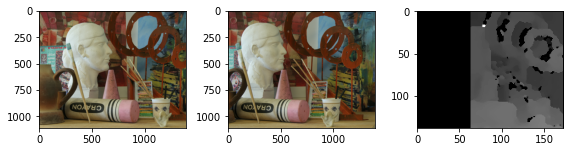


Generating the 3D map...

Creating the output file ... Done.



In [2]:
#=====================================
# Function declarations
#=====================================

# Function to create point cloud file
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

# Function that downsamples the image x number (reduce_factor) of times. 
def downsample_image(image, reduce_factor):
	for i in range(0,reduce_factor):
		
		# Check if image is color or grayscale
		if len(image.shape) > 2:
			row,col = image.shape[:2]
		else:
			row,col = image.shape

		image = cv.pyrDown(image, dstsize= (col//2, row // 2))
	return image


#=========================================================
# Stereo 3D reconstruction 
#=========================================================

# Load camera parameters (that we calibrated in the previous exercise)
ret = np.load('./camera_params/ret.npy')
K = np.load('./camera_params/K.npy')
dist = np.load('./camera_params/dist.npy')

# Specify image paths (two images of the same scene,
# but from two different view points).
img_path1 = '../data/art_left.png'
img_path2 = '../data/art_right.png'

# Load pictures
img_1 = cv.imread(img_path1)
img_2 = cv.imread(img_path2)

# Get height and width. Note: It assumes that both pictures are the same size.
h,w = img_2.shape[:2]

# Get optimal camera matrix for better undistortion 
new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(K, dist, (w,h), 1, (w,h))

# Undistort images
img_1_undistorted = cv.undistort(img_1, K, dist, None, new_camera_matrix)
img_2_undistorted = cv.undistort(img_2, K, dist, None, new_camera_matrix)

# Downsample each image 3 times (because they're too big)
img_1_downsampled = downsample_image(img_1_undistorted, 3)
img_2_downsampled = downsample_image(img_2_undistorted, 3)

# Set disparity parameters
# Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16

# Create Block matching object
stereo = cv.StereoSGBM_create(minDisparity= min_disp,
	numDisparities = num_disp,
	blockSize = 5,
	uniquenessRatio = 5,
	speckleWindowSize = 5,
	speckleRange = 5,
	disp12MaxDiff = 2,
	P1 = 8*3*win_size**2,
	P2 =32*3*win_size**2)

# Compute disparity map
print ("\nComputing the disparity map...")
disparity_map = stereo.compute(img_1_downsampled, img_2_downsampled)

# Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.figure(figsize=(8,8))
plt.subplot(131), plt.imshow(img_1[:,:,::-1])
plt.subplot(132), plt.imshow(img_2[:,:,::-1])
plt.subplot(133), plt.imshow(disparity_map,'gray')
plt.tight_layout(pad=1.0)
plt.show()

# Generate point cloud. 
print ("\nGenerating the 3D map...")

# Get new downsampled width and height 
h,w = img_2_downsampled.shape[:2]

# Load focal length. 
focal_length = np.load('./camera_params/FocalLength.npy')

# This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision. 
# Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
Q = np.float32([[1,0,0,0],
				[0,-1,0,0],
				[0,0,focal_length*0.05,0], # Focal length multiplication obtained experimentally. 
				[0,0,0,1]])

# Reproject points into 3D
points_3D = cv.reprojectImageTo3D(disparity_map, Q)

# Get color points
colors = cv.cvtColor(img_1_downsampled, cv.COLOR_BGR2RGB)

# Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()

# Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]

# Define name for output file
output_file = '3d_reconstruction.ply'

# Generate point cloud 
print("\nCreating the output file ... ", end='')
create_output(output_points, output_colors, output_file)
print ("Done.\n")

In [3]:
# Read the point cloud file
cloud = o3d.io.read_point_cloud(output_file)

# Visualize the point cloud
o3d.visualization.draw_geometries([cloud])